In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

In [2]:
df = pd.read_csv('../data/Tweets.csv')

In [3]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.1+ MB


Looking we see taht some columns have really low non-null object counts.  Columns airline_sentiment_gold has 40, negativereason_gold has 32, and twee_coord only has 1019.  These columns with a lot of missing values won't be of use in the model and will be dropped.  

In [5]:
df_1 = df.drop(['airline_sentiment_gold', 'negativereason_gold', 
                'tweet_coord'], axis=1)

In [8]:
df_1['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

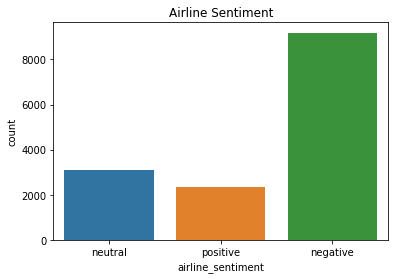

In [6]:
sns.countplot(df_1['airline_sentiment'])
plt.title('Airline Sentiment');

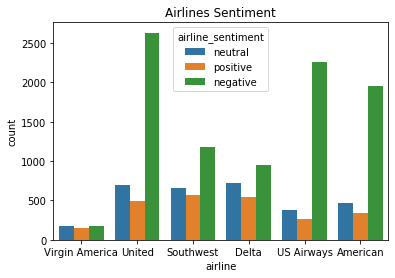

In [7]:
sns.countplot(df_1['airline'], hue=df_1['airline_sentiment'])
plt.title('Airlines Sentiment');

In the graph above we see the airline sentiments of each airline neutral, positive, and negative counts.  We see that all but Virgin America have a lot more negative tweets then neutral or positive and in some cases more then both of them combined.

In [83]:
df_1.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [94]:
columns = ['negativereason', 'airline', 'name', 'tweet_created', 
           'tweet_location', 'user_timezone']

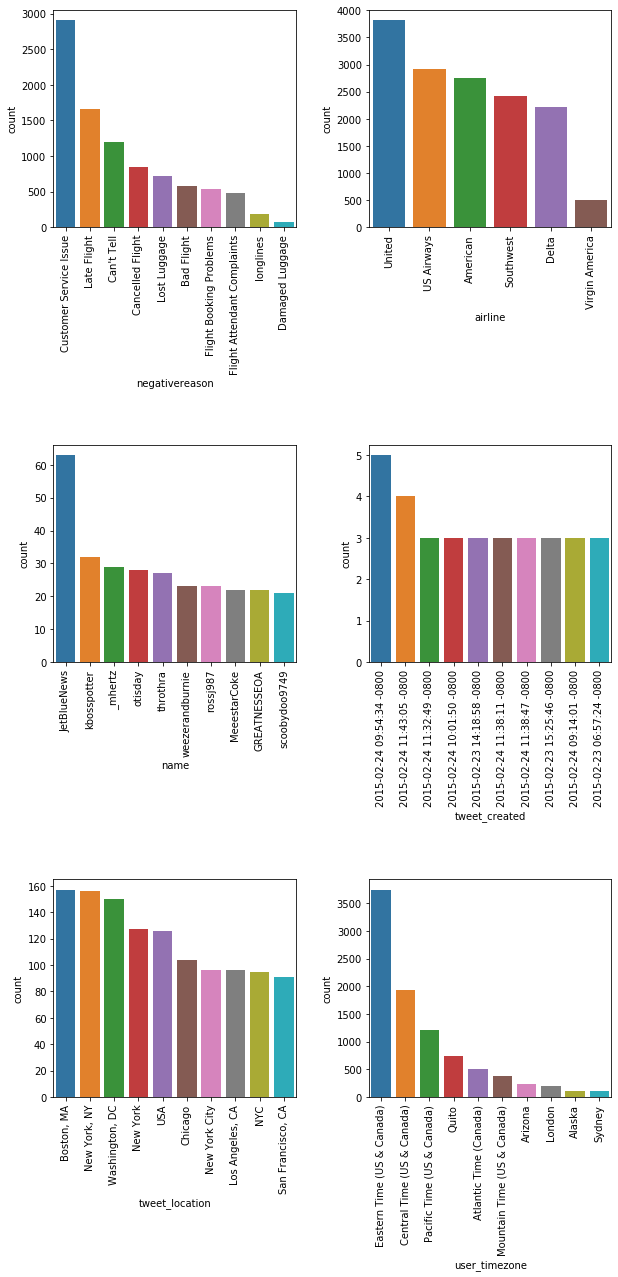

In [103]:
fig = plt.figure(figsize=(10, 20))
fig.subplots_adjust(hspace=1, wspace=0.3)

for i, c in enumerate(columns, start=1):
    ax = fig.add_subplot(3, 2, i)
    chart = sns.countplot(x=c, data=df_1, 
                          order=df_1[c].value_counts().iloc[:10].index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

The graphs above show us the top ten most frequent values in the categorical columns.  We see that columns name, tweet_created, tweet_location have very low counts.  But looking at tweet_created as a different type of date would probably bring the counts up.  We could do day of week, hour, or month date.

In [8]:
df_1['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [24]:
df_1['tweet_location'].value_counts().head(10)

Boston, MA           157
New York, NY         156
Washington, DC       150
New York             127
USA                  126
Chicago              104
New York City         96
Los Angeles, CA       96
NYC                   95
San Francisco, CA     91
Name: tweet_location, dtype: int64

In [11]:
df_1['user_timezone'].value_counts().head(10)

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Name: user_timezone, dtype: int64

In [12]:
df_1[['tweet_location', 'user_timezone']][df_1['tweet_location'].isnull()]

,tweet_location,user_timezone
0,NaN,Eastern Time (US & Canada)
1,NaN,Pacific Time (US & Canada)
3,NaN,Pacific Time (US & Canada)
4,NaN,Pacific Time (US & Canada)
5,NaN,Pacific Time (US & Canada)
13,NaN,Eastern Time (US & Canada)
20,NaN,NaN
21,NaN,NaN
25,NaN,NaN
26,NaN,NaN


In [13]:
us_time = {'Alaska': ['AK', 'ALASKA'], 
           'Central Time (US & Canada)': ['AL', 'AR', 'IL', 'IA', 
                                          'KS', 'KY', 'LA', 'MN', 
                                          'MI', 'MO', 'NE', 'ND', 
                                          'OK', 'SD', 'TN', 'TX', 
                                          'WI', 'ALABAMA', 
                                          'ARKANSAS','ILLINOIS', 
                                          'IOWA', 'KANSAS', 
                                          'KENTUCKY', 'LOUISIANA', 
                                          'MINNESOTA', 'MISSISSIPPI',
                                          'MISSOURI', 'NEBRASKA', 
                                          'NORTH DAKOTA','OKLAHOMA',
                                          'SOUTH DAKOTA','TENNESSEE',
                                          'TEXAS', 'WISCONSIN'], 
           'Eastern Time (US & Canada)': ['CT', 'DE', 'DC', 'FL', 
                                          'GA', 'IN', 'ME', 'MD', 
                                          'MA', 'MI', 'NH', 'NJ', 
                                          'NY', 'NC', 'OH', 'PA', 
                                          'RI', 'SC', 'VT', 'VA', 
                                          'WV', 'CONNECTICUT', 
                                          'DELAWARE', 'FLORIDA', 
                                          'GEORGIA', 'INDIANA', 
                                          'MAINE', 'MARYLAND', 
                                          'MASSACHUSETTS', 
                                          'MICHIGAN','NEW HAMPSHIRE', 
                                          'NEW JERSEY', 'NEW YORK', 
                                          'NORTH CAROLINA', 'OHIO', 
                                          'PENNSYLVANIA', 
                                          'RHODE ISLAND', 
                                          'SOUTH CAROLINA', 
                                          'VERMONT', 'VIRGINIA', 
                                          'WEST VIRGINIA'], 
           'Mountain Time (US & Canada)': ['AZ', 'CO', 'ID', 'MT', 
                                           'NM', 'UT', 'WY', 
                                           'ARIZONA', 'COLORADO', 
                                           'IDAHO', 'MONTANA', 
                                           'NEW MEXICO', 'UTAH', 
                                           'WYOMING'], 
           'Pacific Time (US & Canada)' : ['CA', 'NV', 'OR', 'WA', 
                                           'CALIFORNIA', 'NEVADA', 
                                           'OREGON', 'WASHINGTON']
          }

In [15]:
def try_extract(s, p):
    try:
        s.upper()
        return p.search(s).group(1)
    except (TypeError, AttributeError):
        return s

In [16]:
df_temp = df_1.copy()

In [18]:
for k in us_time.keys():
    l = us_time[k]

    p = re.compile(rf"({'|'.join(l)})")
    df_temp['test_1'] = [try_extract(s, p) for s in df['tweet_location']]
    
df_temp['test'] = df['user_timezone'].fillna(df_temp['test_1'])

In [23]:
df_temp['test'].value_counts().head(12)

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          208
CA                              112
Alaska                          108
Sydney                          107
Hawaii                          104
Name: test, dtype: int64

In [43]:
import datetime

df_temp['day'] = pd.DatetimeIndex(df_temp['tweet_created']).dayofweek
df_temp['day'].value_counts()

6    3079
0    3032
1    2752
5    1557
4    1500
3    1376
2    1344
Name: day, dtype: int64